In [1]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk

data_src = r"data/*"
label_csv = "labelled.csv"
label_df = pd.read_csv(label_csv, index_col="suid")

dst = "cube_64/"

In [2]:
import myPreproc as P
from glob import glob
import matplotlib.pyplot as plt
import time

second = time.time()

j = 16
width = 50
s_ls = []
count_nodule = 0
for case_path in glob(data_src):
    img_array, suid, origin, spacing = P.get_dicom_array_and_info(case_path)
    # 12/2 resample img array
    img_re = P.resample(img_array, spacing[::-1], mode='nearest', order=1)
    
    
    
    img_pad = np.pad(img_re, ((width,width),(width,width),(width,width)), mode='minimum')
    print(suid)
    print('Img shape', img_array.shape) # (194, 512, 512) (z, y, x)
    print('Resample Img shape', img_re.shape) # (349, 330, 330)
    print('Padding Img shape', img_pad.shape) # (294, 612, 612)
    print('Origin:', origin) # x,y,z
    print('Spacing:', spacing) # x,y,z
    print('reversed Spacing', spacing[::-1])
    
#     save_folder = os.path.join(dst, suid)
#     if not os.path.exists(save_folder):
#         os.makedirs(save_folder)
    
    pred_coord = label_df.loc[suid]
    if len(pred_coord) != 1:
        count = 0
        for i in range(len(pred_coord)):
            pred_x, pred_y, pred_z = pred_coord["x"].iloc[i], pred_coord["y"].iloc[i], pred_coord["z"].iloc[i]
            c = pred_coord["class"].iloc[i]
            print('Pred coord', pred_x, pred_y, pred_z, "Class:", c)
            voxelCoord = P.worldToVoxelCoord((pred_x, pred_y, pred_z), origin, spacing)
            print('Voxel coord', voxelCoord) #  x, y, z
#             z1, z2 = int(voxelCoord[2])-j + width, int(voxelCoord[2])+j + width
#             x1, x2 = int(voxelCoord[0])-j + width, int(voxelCoord[0])+j + width
#             y1, y2 = int(voxelCoord[1])-j + width, int(voxelCoord[1])+j + width
            
            z1, z2 = int(round(voxelCoord[2])*spacing[2] -j + width), int(round(voxelCoord[2])*spacing[2] +j + width)
            x1, x2 = int(round(voxelCoord[0])*spacing[0] -j + width), int(round(voxelCoord[0])*spacing[0] +j + width)
            y1, y2 = int(round(voxelCoord[1])*spacing[1] -j + width), int(round(voxelCoord[1])*spacing[1] +j + width)
            
#             print((z1, z2), (x1, x2), (y1, y2))
            
            cube = img_pad[z1:z2, y1:y2, x1:x2]
            count_nodule += 1
            print("-----------")
#             assert cube.shape == (2*j, 2*j, 2*j), cube.shape
            
# #             cube_fname = save_folder + "/cube_" + str(count) + "_" + str(c) + ".npy"
# #             count += 1
# #             if not os.path.exists(cube_fname):
# #                 print(f"save cube npy -> {cube_fname}")
# #                 np.save(cube_fname, cube)
            break
#     else:
#         s_ls.append(suid)
    
    break
end = time.time()
print((end - second)/60)
# print(count_nodule)

0.0


In [5]:
# v2 
import myPreproc as P
from glob import glob
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import time
from importlib import reload
reload(P)

j = 16
width = 50
fail_ls, s_ls = [], []
count_nodule = 0 # count total nodule numbers
for case_path in glob(data_src):
    img_array, suid, origin, spacing = P.get_dicom_array_and_info(case_path)
    lungwin_array = P.lumTrans(img_array)
    img_re = P.resample(lungwin_array, spacing[::-1], mode='nearest', order=1)    
    print(suid)
    print('Img shape', img_array.shape) # (194, 512, 512) (z, y, x)
    print('Resample Img shape', img_re.shape) # z,y,x
#     print('Origin:', origin) # x,y,z
#     print('Spacing:', spacing) # x,y,z

    save_folder = os.path.join(dst, suid)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    pred_coord = label_df.loc[suid]
    if len(pred_coord) != 1:
        count = 0 # count predicted nodule in one suid
#         tmp_coord = [] # storing resample coord for rotation
        for i in range(len(pred_coord)):
            tmp_coord = [] # storing resample coord for rotation
            pred_x, pred_y, pred_z = pred_coord["x"].iloc[i], pred_coord["y"].iloc[i], pred_coord["z"].iloc[i]
            c = pred_coord["class"].iloc[i]
            print('Pred coord', pred_x, pred_y, pred_z, "Class:", c)
            voxelCoord = P.worldToVoxelCoord((pred_x, pred_y, pred_z), origin, spacing) # x,y,z
            re_z, re_y, re_x = round(voxelCoord[2]*spacing[2]), round(voxelCoord[1]*spacing[1]), round(voxelCoord[0]*spacing[0])
            tmp_coord.append([re_z, re_y, re_x])
            print(tmp_coord)
#             tmp_coord = [re_z, re_y, re_x]

            img_pad = np.pad(img_re, ((width,width),(width,width),(width,width)), mode='minimum')
            z1, z2 = int(round(re_z -j + width)), int(round(re_z +j + width))
            x1, x2 = int(round(re_x -j + width)), int(round(re_x +j + width))
            y1, y2 = int(round(re_y -j + width)), int(round(re_y +j + width))
            cube = img_pad[z1:z2, y1:y2, x1:x2]
            cube_fname = save_folder + "/cube_" + str(count) + "_" + str(c) + ".npy"
            count_nodule = P.saveCube(cube, cube_fname, count_nodule, 0, j, fail_ls)
            
            # rotate images & coord
            if c == 1:
                rot_arr_ls = P.augmentation(img_re)
                rot_coord_ls = P.getRotCoord(img_re, tmp_coord)
                # make rot cube
                rot_cube_ls = P.getRotCube(rot_arr_ls, rot_coord_ls, tmp_coord, j, width)
                for k, item in enumerate(rot_cube_ls):
                    cube_fname = save_folder + "/cube_" + str(count) + "_" + str(c) + "_" + str(k) + ".npy"
                    count_nodule = P.saveCube(item, cube_fname, count_nodule, 1, j, fail_ls)

            count += 1
            print("----------")
#             break
    else:
        s_ls.append(suid)

    break

1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427
Img shape (133, 512, 512)
Resample Img shape (332, 330, 330)
Pred coord 4.480555481000001 -97.49003048 -12.11341858 Class: 0
[[339, 54, 169]]
----------
Pred coord -48.57130096 84.93388883 -182.04700469999997 Class: 1
[[169, 236, 116]]
----------
Pred coord -52.1194866 55.71618609 -201.9865894 Class: 0
[[149, 207, 113]]
----------
Pred coord 56.10934145 86.2445283 -184.68561169999998 Class: 1
[[167, 237, 221]]
----------
Pred coord -54.67383998 -21.07627579 -169.9570847 Class: 1
[[181, 130, 110]]
----------
Pred coord -86.14498187 71.27086625 -257.5854397 Class: 0
[[94, 222, 79]]
----------
Pred coord -88.456215 -4.000000513 -184.2190742 Class: 1
[[167, 147, 77]]
----------
Pred coord -83.25499755 75.97025019 -218.43661310000002 Class: 0
[[133, 227, 82]]
----------
Pred coord -88.08828670000001 25.3581033 -164.7587013 Class: 0
[[186, 176, 77]]
----------
Pred coord -73.06319376 15.31496177 -217.31180189999998 Class: 0
[[1

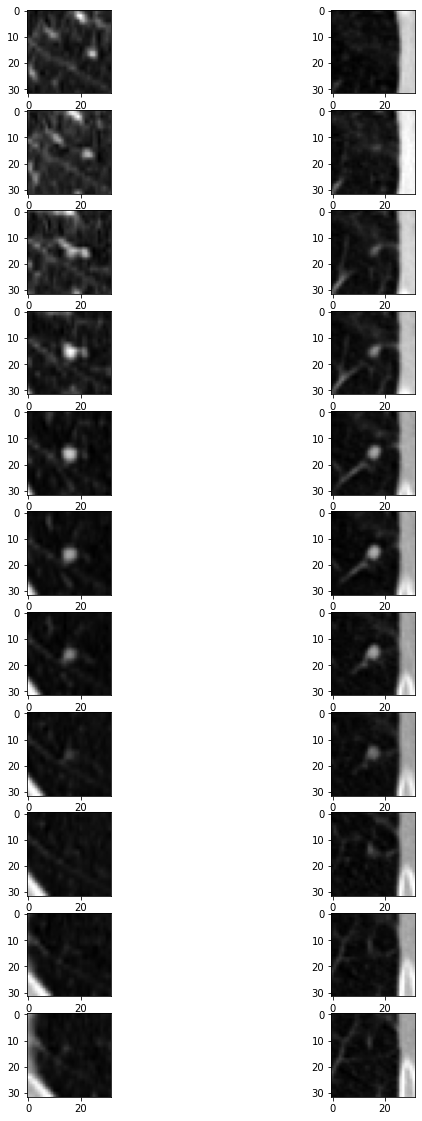

In [14]:
import numpy as np
import matplotlib.pyplot as plt

path1 = r'C:\Users\TMU_AIMC\Desktop\james\honghu\FalsePositiveReduction\cube_64\cube_0_1_1.npy'
path2 = r'C:\Users\TMU_AIMC\Desktop\james\honghu\FalsePositiveReduction\cube_64\cube_0_1_0.npy'

a = np.load(path1)
b = np.load(path2)

fig, ax = plt.subplots(11, 2, figsize=(10,20))

for i, s in enumerate(range(11,22)):
#     plt.imshow(a[:,s,:], cmap='gray')
#     plt.imshow(b[s,:,:], cmap='gray')

    ax[i,0].imshow(a[:,s,:], cmap='gray')
    ax[i,1].imshow(b[s,:,:], cmap='gray')
    
plt.show()

In [4]:
print(img_re.shape)
print(rot_arr_ls[0].shape)
print(tmp_coord)
print(re_z)
plt.imshow(img_re[re_z, :,:], cmap='gray')
plt.scatter(re_x, re_y, color='',marker='o', edgecolors='r', s=200)
plt.show()

plt.imshow(rot_arr_ls[0][163,:,:], cmap='gray')
plt.scatter(116, 236, color='',marker='o', edgecolors='r', s=200)
plt.show()

NameError: name 'img_re' is not defined

(32, 32, 32)


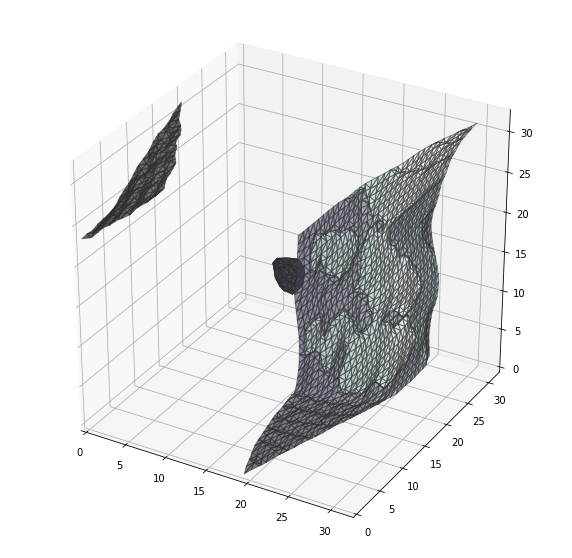

In [16]:
# from importlib import reload
# reload(P)
import myPreproc as P
P.plt_3d(b) # z,y,x

In [ ]:
# v2
print(spacing)
m_slice = round(voxelCoord[2])
nm_slice = round(m_slice * spacing[2])

n_x, n_y = round(voxelCoord[0])*spacing[0], round(voxelCoord[1])*spacing[1]

print(img_re[nm_slice,:,:].shape)

# plt.imshow(img_array[], cmap='gray')
# plt.imshow(cube[j,:,:], cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(img_array[m_slice,:,:], cmap='gray')
ax[0].scatter(round(voxelCoord[0]), round(voxelCoord[1]), color='r')
ax[1].imshow(img_re[nm_slice,:,:], cmap='gray')
ax[1].scatter(n_x, n_y, color='r')
plt.show()

In [ ]:
print(spacing)
m_slice = round(voxelCoord[2])
nm_slice = round(m_slice * spacing[2])

n_x, n_y = round(voxelCoord[0])*spacing[0], round(voxelCoord[1])*spacing[1]

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(img_array[m_slice,:,:], cmap='gray')
ax[0].scatter(round(voxelCoord[0]), round(voxelCoord[1]), color='r')
ax[1].imshow(img_re[nm_slice,:,:], cmap='gray')
ax[1].scatter(n_x, n_y, color='r')
plt.show()

In [ ]:
# 有問題的case
print('Pred coord', pred_x, pred_y, pred_z, "Class:", c)

In [ ]:
print('slice_z:', int(voxelCoord[2]))
print('shape of img', img_array.shape)
plt.figure(figsize=(8,8))

plt.imshow(img_array[int(voxelCoord[2]),y1-width:y2-width,x1-width:x2-width], cmap='gray')
# plt.scatter(int(voxelCoord[0]), int(voxelCoord[1]), color='r')
# plt.imshow(img_array[int(voxelCoord[2]),:,:], cmap='gray')
plt.show()

In [ ]:
# for i in range():
print('shape of padding img:', cube.shape)
for i in range(17):
    plt.figure()
    plt.imshow(cube[i+10,:,:], cmap='gray')
    plt.show()

In [ ]:
(pred_x, pred_y, pred_z)[::-1]

In [ ]:
(pred_x, pred_y, pred_z) - origin

In [ ]:
print(29.43152928 / 0.64453125)
print(round(29.43152928 / 0.64453125))
print(int(29.43152928 / 0.64453125))